# The Stock Price Relationship between Apple Inc. and Foxconn
B036060017 資管系四年級 謝威廷, 2018/3/31 

## Introduction
- 目標預測鴻海的收盤價，並未限定輸入的資料，可以是之前的蘋果公司和鴻海股票的任何資訊(如開盤價,收盤價,成交量...)

## Outline
1. Data Preprocessing
2. Model Construction : Linear Regression
3. Feature Engineering
4. Robust Model Construction : Random Forest, Long Short-term Memory
5. Conclusion
6. *Appendix : Missmatch Date Observation

## 1. Data Preprocessing
- Load the Apple and Foxconn stock dataset.
- Preprocess the `Date` and `Volume` column.
    - Format `Date` to datetime
    - Adjust `Volume` of Apple and Foxconn to same units
- Remove the outlier in foxconn dataset.
- Align the datetime, and combine above two input source into one dataset.

### 1.1 Apple Stock

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import files

uploaded = files.upload()

Saving apple.csv to apple.csv
Saving foxconn.csv to foxconn.csv


In [0]:
colnames = ['Date', 'Open_A', 'High_A', 'Low_A', 'Close_A', 'Volume_A']

apple = pd.read_csv('apple.csv', encoding = 'utf-8', parse_dates=True)
apple.columns = colnames
apple['Date'] = pd.to_datetime(apple['Date'], format = '%Y/%m/%d')

In [5]:
import re

volume_list = []

# Convert million and million to actual number 
pattern = re.compile(".*[B]")
for i in apple['Volume_A'].values:
    if pattern.match(i):
        i = i.replace(r'.', '').replace(r'B', '00000000')
        volume_list.append(i)
    else:
        i = i.replace(r'.', '').replace(r'M', '000000')
        volume_list.append(i)

apple['Volume_A'] = volume_list

print("Apple Stock : ", apple.shape)
apple.head()

Apple Stock :  (6926, 6)


,Date,Open_A,High_A,Low_A,Close_A,Volume_A
0,1990-01-02,1.3304,1.3393,1.2500,1.3304,4580000000
1,1990-01-03,1.3393,1.3571,1.3393,1.3393,5200000000
2,1990-01-04,1.3437,1.3839,1.3304,1.3437,5538000000
3,1990-01-05,1.3482,1.3661,1.3214,1.3482,3083000000
4,1990-01-08,1.3571,1.3571,1.3214,1.3571,2539000000


### 1.2 Foxconn Stock

In [6]:
colnames = ['Date', 'Open_F', 'High_F', 'Low_F', 'Close_F', 'Volume_F']

foxconn = pd.read_csv('foxconn.csv', encoding = 'utf-8', parse_dates=True)
foxconn.columns = colnames
foxconn['Date'] = pd.to_datetime(foxconn['Date'], format = '%Y/%m/%d')

# Drop out the first 10 row, because the volume seems weird
foxconn = foxconn.drop(foxconn.index[0:10])
print("Foxconn Stock : ", foxconn.shape)
foxconn.head()

Foxconn Stock :  (6751, 6)


,Date,Open_F,High_F,Low_F,Close_F,Volume_F
10,1991-06-29,85.5,85.5,85.5,85.5,2221
11,1991-07-02,89.0,89.0,82.5,82.5,2670
12,1991-07-03,82.0,82.5,80.0,82.0,1298
13,1991-07-04,80.5,87.5,80.5,87.5,1880
14,1991-07-05,88.0,89.0,85.0,88.0,2475


### 1.3 Combine Dataset
- Taiwan stock market is influenced by the last day of US stock market
- In order to combine two different stock data, needs to minus US stock datetime by one day.
- Last, only left 4993 valid row data after data preprocessing stage.

In [7]:
from datetime import datetime, timedelta

# Minus Apple stock datetime one day
apple['Date'] = apple['Date'] - timedelta(days=1)
 
# Choose the same period with foxconn
start_date = foxconn.iloc[0, 0]
end_date = foxconn.iloc[-1, 0]

mask = (apple['Date'] >= start_date) & (apple['Date'] <= end_date)
apple = apple.loc[mask]

stock = pd.merge(apple, foxconn, on = 'Date', how = 'inner', indicator = True)
print("Stock size after merge : ", stock.shape)
stock.head()

Stock size after merge :  (4993, 12)


,Date,Open_A,High_A,Low_A,Close_A,Volume_A,Open_F,High_F,Low_F,Close_F,Volume_F,_merge
0,1991-07-02,1.5402,1.5536,1.4911,1.5402,7619000000,89.0,89.0,82.5,82.5,2670,both
1,1991-07-04,1.6295,1.6429,1.5268,1.6295,8289000000,80.5,87.5,80.5,87.5,1880,both
2,1991-07-08,1.6741,1.7232,1.6607,1.6741,5661000000,83.0,86.0,82.0,82.0,1018,both
3,1991-07-09,1.6875,1.7232,1.6696,1.6875,3914000000,83.0,83.5,80.5,82.0,675,both
4,1991-07-10,1.6696,1.6875,1.6429,1.6696,3648000000,83.5,84.0,82.0,84.0,690,both


In [8]:
stock_final = stock.iloc[:, np.r_[1:5, 9]]
stock_final.head()

,Open_A,High_A,Low_A,Close_A,Close_F
0,1.5402,1.5536,1.4911,1.5402,82.5
1,1.6295,1.6429,1.5268,1.6295,87.5
2,1.6741,1.7232,1.6607,1.6741,82.0
3,1.6875,1.7232,1.6696,1.6875,82.0
4,1.6696,1.6875,1.6429,1.6696,84.0


### 1.4 Split the Training and Test dataset

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stock_final.iloc[:, :-1], stock_final.iloc[:, -1],
                                                    test_size = 0.2, random_state = 10)
print("X_train Shape : ", X_train.shape, ", X_test Shape : ", X_test.shape)

X_train Shape :  (3994, 4) , X_test Shape :  (999, 4)


## 2. Model Construction
### 2.1 Linear Regression Pipeline
- In the first trial, we achieved **MSE test score 3060.323 as Baseline Benchmark**.
- Proposed further advanced techniques to see whether enhance the performance metrics or not.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('reg', LinearRegression())])
pipe_lr.fit(X_train, y_train)

score_mse_lr = cross_val_score(estimator = pipe_lr,
                               X = X_train,
                               y = y_train,
                               cv = 10,
                               scoring = "neg_mean_squared_error",
                               n_jobs = -1)
predict_lr = pipe_lr.predict(X_test)

print("CV MSE Scores : %.3f +/- %.3f" %(np.negative(np.mean(score_mse_lr)), np.std(score_mse_lr)))
print("Test MSE %.3f" %mean_squared_error(y_test, predict_lr))

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CV MSE Scores : 3190.565 +/- 307.050
Test MSE 3060.323


## 3. Feature Engineering
### 3.1 Create Gap Ratio in Single Day Feature
$$Gap \;Ratio = \frac{Close\; - \; Open}{Close}$$

In [11]:
# Gap Ratio
stock_final.loc[:, "GapRation"] = (stock_final.Close_A - stock_final.Open_A)/stock_final.Close_A
stock_final.head()

,Open_A,High_A,Low_A,Close_A,Close_F,GapRation
0,1.5402,1.5536,1.4911,1.5402,82.5,0.0
1,1.6295,1.6429,1.5268,1.6295,87.5,0.0
2,1.6741,1.7232,1.6607,1.6741,82.0,0.0
3,1.6875,1.7232,1.6696,1.6875,82.0,0.0
4,1.6696,1.6875,1.6429,1.6696,84.0,0.0


### 3.2 Create Return Feature
$$Return = \ln(\frac{Close_{t}}{Close_{t-1}})$$

In [12]:
# Return
return_list = []

for i in range(stock_final.shape[0]-1):
    ret = np.log(stock_final.iloc[i, 3] / stock_final.iloc[i+1, 3])
    return_list.append(ret)

## Delete the fist row that can't calculate Return
stock_final = stock_final.iloc[1:, :]
stock_final["Return"] = return_list

## Alter the column order
cols = stock_final.columns.tolist()
cols = cols[:4] + cols[5:] + cols[4:5]
stock_final = stock_final[cols]
stock_final.head()

,Open_A,High_A,Low_A,Close_A,GapRation,Return,Close_F
1,1.6295,1.6429,1.5268,1.6295,0.0,-0.056361,87.5
2,1.6741,1.7232,1.6607,1.6741,0.0,-0.027002,82.0
3,1.6875,1.7232,1.6696,1.6875,0.0,-0.007972,82.0
4,1.6696,1.6875,1.6429,1.6696,0.0,0.010664,84.0
5,1.6696,1.6875,1.6518,1.6696,0.0,0.000000,82.0


### 3.3 Split the new dataset after feature engineering

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stock_final.iloc[:, :-1], stock_final.iloc[:, -1],
                                                    test_size = 0.2, random_state = 10)
print("X_train Shape : ", X_train.shape, ", X_test Shape : ", X_test.shape)

X_train Shape :  (3993, 6) , X_test Shape :  (999, 6)


## 4. Robust Model Construction
- Compare with original Linear Regression to observe whether feature engineering is useful.
- Construct with ensemble method model, i.e. Random Forest

### 4.1 The Effort of Feature Engineering
- Slight improvement on Test MSE, thus feature engineering do work!

In [14]:
pipe_lr.fit(X_train, y_train)

score_mse_lr = cross_val_score(estimator = pipe_lr,
                               X = X_train,
                               y = y_train,
                               cv = 10,
                               scoring = "neg_mean_squared_error",
                               n_jobs = -1)

predict_lr_fe = pipe_lr.predict(X_test)

print("CV MSE Scores : %.3f +/- %.3f" %(np.negative(np.mean(score_mse_lr)), np.std(score_mse_lr)))
print("Test MSE Scores : %.3f" %mean_squared_error(y_test, predict_lr_fe))

CV MSE Scores : 3210.573 +/- 234.080
Test MSE Scores : 2992.890


### 4.2 Ensemble Method : Random Forest
- Significant improvement !!!

In [15]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('reg', RandomForestRegressor(n_estimators = 500, random_state = 10))])
pipe_rf.fit(X_train, y_train)

score_mse_rf = cross_val_score(estimator = pipe_rf,
                               X = X_train,
                               y = y_train,
                               cv = 10,
                               scoring = "neg_mean_squared_error",
                               n_jobs = -1)

predict_rf = pipe_rf.predict(X_test)

print("CV MSE Scores : %.3f +/- %.3f" %(np.negative(np.mean(score_mse_rf)), np.std(score_mse_rf)))
print("Test MSE Scores : %.3f" %mean_squared_error(y_test, predict_rf))

CV MSE Scores : 2039.792 +/- 224.142
Test MSE Scores : 1658.978


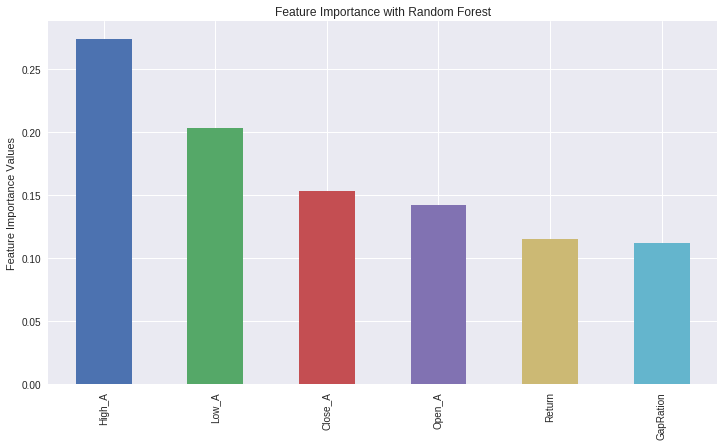

In [16]:
imp_features = pd.Series(pipe_rf.steps[1][1].feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_features.plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance Values')
plt.subplots_adjust(bottom=0.25)
plt.show()

### 4.3 Long Short-Term Memort, LSTM

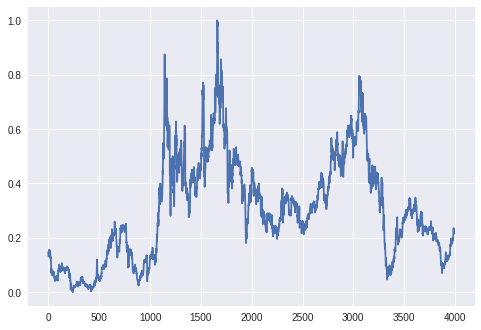

In [57]:
import math
# Only using Foxconn's close price to predcit
train_test_split = math.ceil(stock.shape[0] * 0.8)
trainset = stock.iloc[:train_test_split, -3].values

from sklearn.preprocessing import MinMaxScaler
minmaxsc = MinMaxScaler(feature_range = (0, 1))
trainset = np.reshape(trainset, (-1, 1))
trainset_sc = minmaxsc.fit_transform(trainset)

plt.plot(trainset_sc)

In [0]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, trainset_sc.shape[0]):
    X_train.append(trainset_sc[i-60:i, 0])
    y_train.append(trainset_sc[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping to 3D np.array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [63]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model_lstm = Sequential()

# 4 LSTM Layers
model_lstm.add(LSTM(units = 50,
                    input_shape = (X_train.shape[1], 1),
                    return_sequences = True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 50,
                    return_sequences = True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 50,
                    return_sequences = True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 50))
model_lstm.add(Dropout(0.2))

# Final Layer : regression \output one number
model_lstm.add(Dense(units = 1))
               
# Compile then fit the model
model_lstm.compile(optimizer = 'adam',
                   loss = 'mean_squared_error')
model_lstm.fit(X_train, y_train, 
               epochs = 100, batch_size = 128)

Epoch 1/100
3935/3935 [==============================] - 19s 5ms/step - loss: 0.0255
Epoch 2/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0048
Epoch 3/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0037
Epoch 4/100
3935/3935 [==============================] - 18s 4ms/step - loss: 0.0039
Epoch 5/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0035
Epoch 6/100
3935/3935 [==============================] - 18s 4ms/step - loss: 0.0035
Epoch 7/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0032
Epoch 8/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0030
Epoch 9/100
 512/3935 [==>...........................] - ETA: 15s - loss: 0.0027

3935/3935 [==============================] - 17s 4ms/step - loss: 0.0029
Epoch 10/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0029
Epoch 11/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0029
Epoch 12/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0025
Epoch 13/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0024
Epoch 14/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0023
Epoch 15/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0022
Epoch 16/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0023
Epoch 17/100
 896/3935 [=====>........................] - ETA: 13s - loss: 0.0022

3935/3935 [==============================] - 17s 4ms/step - loss: 0.0022
Epoch 18/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0019
Epoch 19/100
3935/3935 [==============================] - 18s 4ms/step - loss: 0.0021
Epoch 20/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0020
Epoch 21/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0018
Epoch 22/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0018
Epoch 23/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0018
Epoch 24/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0018
Epoch 25/100
 896/3935 [=====>........................] - ETA: 13s - loss: 0.0015

3935/3935 [==============================] - 17s 4ms/step - loss: 0.0017
Epoch 26/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0018
Epoch 27/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0017
Epoch 28/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0016
Epoch 29/100
3935/3935 [==============================] - 18s 4ms/step - loss: 0.0015
Epoch 30/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0016
Epoch 31/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0016
Epoch 32/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0015
Epoch 33/100
 896/3935 [=====>........................] - ETA: 13s - loss: 0.0016

3935/3935 [==============================] - 18s 4ms/step - loss: 0.0015
Epoch 34/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0015
Epoch 35/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0014
Epoch 36/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0014
Epoch 37/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0014
Epoch 38/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0013
Epoch 39/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0013
Epoch 40/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0013
Epoch 41/100
 896/3935 [=====>........................] - ETA: 13s - loss: 0.0014

3935/3935 [==============================] - 17s 4ms/step - loss: 0.0013
Epoch 42/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0013
Epoch 43/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0012
Epoch 44/100
3935/3935 [==============================] - 18s 4ms/step - loss: 0.0013
Epoch 45/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0013
Epoch 46/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 47/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 48/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0010
Epoch 49/100
 896/3935 [=====>........................] - ETA: 13s - loss: 0.0014

3935/3935 [==============================] - 17s 4ms/step - loss: 0.0012
Epoch 50/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0012
Epoch 51/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 52/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 53/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 54/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0010
Epoch 55/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 56/100
3935/3935 [==============================] - 17s 4ms/step - loss: 9.4527e-04
Epoch 57/100
 896/3935 [=====>........................] - ETA: 13s - loss: 0.0010

3935/3935 [==============================] - 17s 4ms/step - loss: 9.9344e-04
Epoch 58/100
3935/3935 [==============================] - 17s 4ms/step - loss: 9.7515e-04
Epoch 59/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 60/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0010
Epoch 61/100
3935/3935 [==============================] - 18s 4ms/step - loss: 9.8841e-04
Epoch 62/100
3935/3935 [==============================] - 17s 4ms/step - loss: 0.0011
Epoch 63/100
3935/3935 [==============================] - 17s 4ms/step - loss: 9.4918e-04
Epoch 64/100
3935/3935 [==============================] - 17s 4ms/step - loss: 9.8905e-04
Epoch 65/100
 384/3935 [=>............................] - ETA: 15s - loss: 8.4145e-04

3935/3935 [==============================] - 17s 4ms/step - loss: 9.4456e-04
Epoch 66/100
3935/3935 [==============================] - 17s 4ms/step - loss: 9.5343e-04
Epoch 67/100
3935/3935 [==============================] - 18s 4ms/step - loss: 8.9586e-04
Epoch 68/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.7331e-04
Epoch 69/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.4197e-04
Epoch 70/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.4297e-04
Epoch 71/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.8507e-04
Epoch 72/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.0941e-04
Epoch 73/100
 128/3935 [..............................] - ETA: 16s - loss: 8.3393e-04

3935/3935 [==============================] - 17s 4ms/step - loss: 9.0799e-04
Epoch 74/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.1142e-04
Epoch 75/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.7418e-04
Epoch 76/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.9675e-04
Epoch 77/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.5602e-04
Epoch 78/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.2065e-04
Epoch 79/100
3935/3935 [==============================] - 18s 4ms/step - loss: 7.9813e-04
Epoch 80/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.8296e-04
Epoch 81/100
 128/3935 [..............................] - ETA: 17s - loss: 9.3714e-04

3935/3935 [==============================] - 17s 4ms/step - loss: 8.7612e-04
Epoch 82/100
3935/3935 [==============================] - 17s 4ms/step - loss: 9.5212e-04
Epoch 83/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.3740e-04
Epoch 84/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.8894e-04
Epoch 85/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.7756e-04
Epoch 86/100
3935/3935 [==============================] - 18s 4ms/step - loss: 7.2568e-04
Epoch 87/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.2019e-04
Epoch 88/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.5078e-04
Epoch 89/100
 128/3935 [..............................] - ETA: 17s - loss: 6.1783e-04

3935/3935 [==============================] - 17s 4ms/step - loss: 7.8736e-04
Epoch 90/100
3935/3935 [==============================] - 17s 4ms/step - loss: 8.0168e-04
Epoch 91/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.4569e-04
Epoch 92/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.8441e-04
Epoch 93/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.7625e-04
Epoch 94/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.2403e-04
Epoch 95/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.3754e-04
Epoch 96/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.2772e-04
Epoch 97/100
 128/3935 [..............................] - ETA: 17s - loss: 7.9927e-04

3935/3935 [==============================] - 17s 4ms/step - loss: 6.9710e-04
Epoch 98/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.4820e-04
Epoch 99/100
3935/3935 [==============================] - 17s 4ms/step - loss: 7.0928e-04
Epoch 100/100
3935/3935 [==============================] - 17s 4ms/step - loss: 6.8870e-04


In [74]:
X_test = stock.iloc[train_test_split:, -3]
real_stock_price = stock.iloc[train_test_split:, -3].values

X_total = stock.iloc[:, -3]
inputs = X_total[len(X_total) - len(X_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = minmaxsc.transform(inputs)

# Shape : 60(train) + 998(test) = 1058
print(inputs.shape)

(1058, 1)


In [75]:
# Creating a data structure with 60 timesteps
X_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predict_lstm = model_lstm.predict(X_test)
predict_lstm = minmaxsc.inverse_transform(predict_lstm)

print("Test MSE Scores : %.3f" %mean_squared_error(y_test, predict_rf))

Test MSE Scores : 1658.978


## 5. Conclusion
- Observe the prediction made by each model
- Among 3 approachs, the Random Forest outperform the others, receiving minimum 1658 MSE test score.

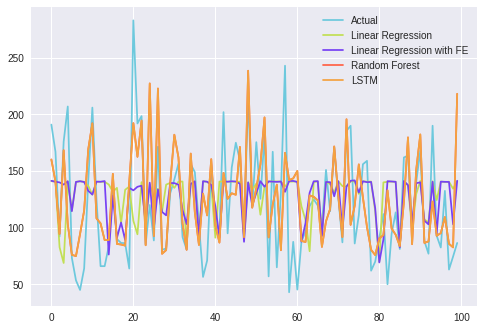

In [82]:
range_num = 100

plt.plot(y_test.values[:range_num], color = '#6dc9dd', label = "Actual")
plt.plot(predict_lr[:range_num], color = '#c2df55', label = 'Linear Regression')
plt.plot(predict_lr_fe[:range_num], color = '#7741f4', label = 'Linear Regression with FE')
plt.plot(predict_rf[:range_num], color = '#ff6347', label = "Random Forest")
plt.plot(predict_rf[:range_num], color = '#f4a341', label = "LSTM")

plt.legend()

### * Appedix : Mismatch Date Observation

In [18]:
total = pd.merge(apple, foxconn, on = 'Date', how = 'outer', indicator = True)
total['_merge'].value_counts()

both          4993
right_only    1758
left_only     1555
Name: _merge, dtype: int64

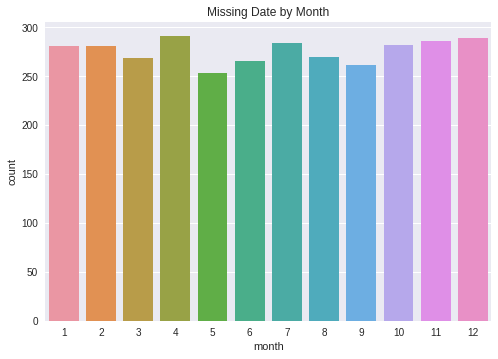

In [19]:
diff_time = total.query('_merge != "both"')
diff_time['month'] = diff_time.loc[:, 'Date'].dt.month

sns.set(style="darkgrid")
ax = sns.countplot(x="month", data=diff_time).set_title('Missing Date by Month')